# Transfer Learning with TensorFlow Part 2: Fine-tuning

* In the previous notebook (04), we used feature extraction. Now let's use a different kind of transfer learning: **Fine-tuning**

In [ ]:
# Checking if we're using a GPU:
!nvidia-smi

Thu Jul 20 05:45:39 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Create a helper function:

Since we are writing functions over and over, let's save them on Github and import them: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

Therefore, it's a good idea to put all functions likely to be used again in a script we can download and import into our notebooks (or somewhere else).


In [ ]:
!wget "https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py"

--2023-07-20 05:45:39--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-07-20 05:45:40 (77.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import helper functions we're going to use in this notebook:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir


**NOTE:** If we exit Colab and and runtime runs out, then  Colab will delete `helper_functions.py`.
Therefore, we'll have to redownload it to access them again.

## Getting data:

We'll see how to use the pretrained models within tf.keras.applications, and apply them into our own problem of recognizing images of food.

https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [ ]:
# Getting 10% of training data of 10 classes of Food101 (same dataset as in the previous notebook)

!wget "https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip"

unzip_data("10_food_classes_10_percent.zip")

--2023-07-20 05:45:41--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.97.128, 142.250.157.128, 142.251.8.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.97.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.2’

10_food_classes_10_ 100%[===================>] 160.74M  30.6MB/s    in 6.1s    

2023-07-20 05:45:47 (26.3 MB/s) - ‘10_food_classes_10_percent.zip.2’ saved [168546183/168546183]



In [ ]:
# Check out how many images and subdirectories there are in our dataset:
walk_through_dir("10_food_classes_10_percent.zip")

In [ ]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [ ]:
import tensorflow as tf

# Using ImageDataFromDirectory instead of ImageDataGenerator:BECAUSE ->>> It creates a much convinient data type (tf.data.Dataset) and it's much faster!

# Global variables:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# preprocessing truns our data into batches:
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir,
                                                                         image_size = IMG_SIZE,
                                                                         label_mode = 'categorical',
                                                                         batch_size = BATCH_SIZE)
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir,
                                                                        image_size = IMG_SIZE,
                                                                        label_mode = 'categorical',
                                                                        batch_size = BATCH_SIZE)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train_data_10_percent

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

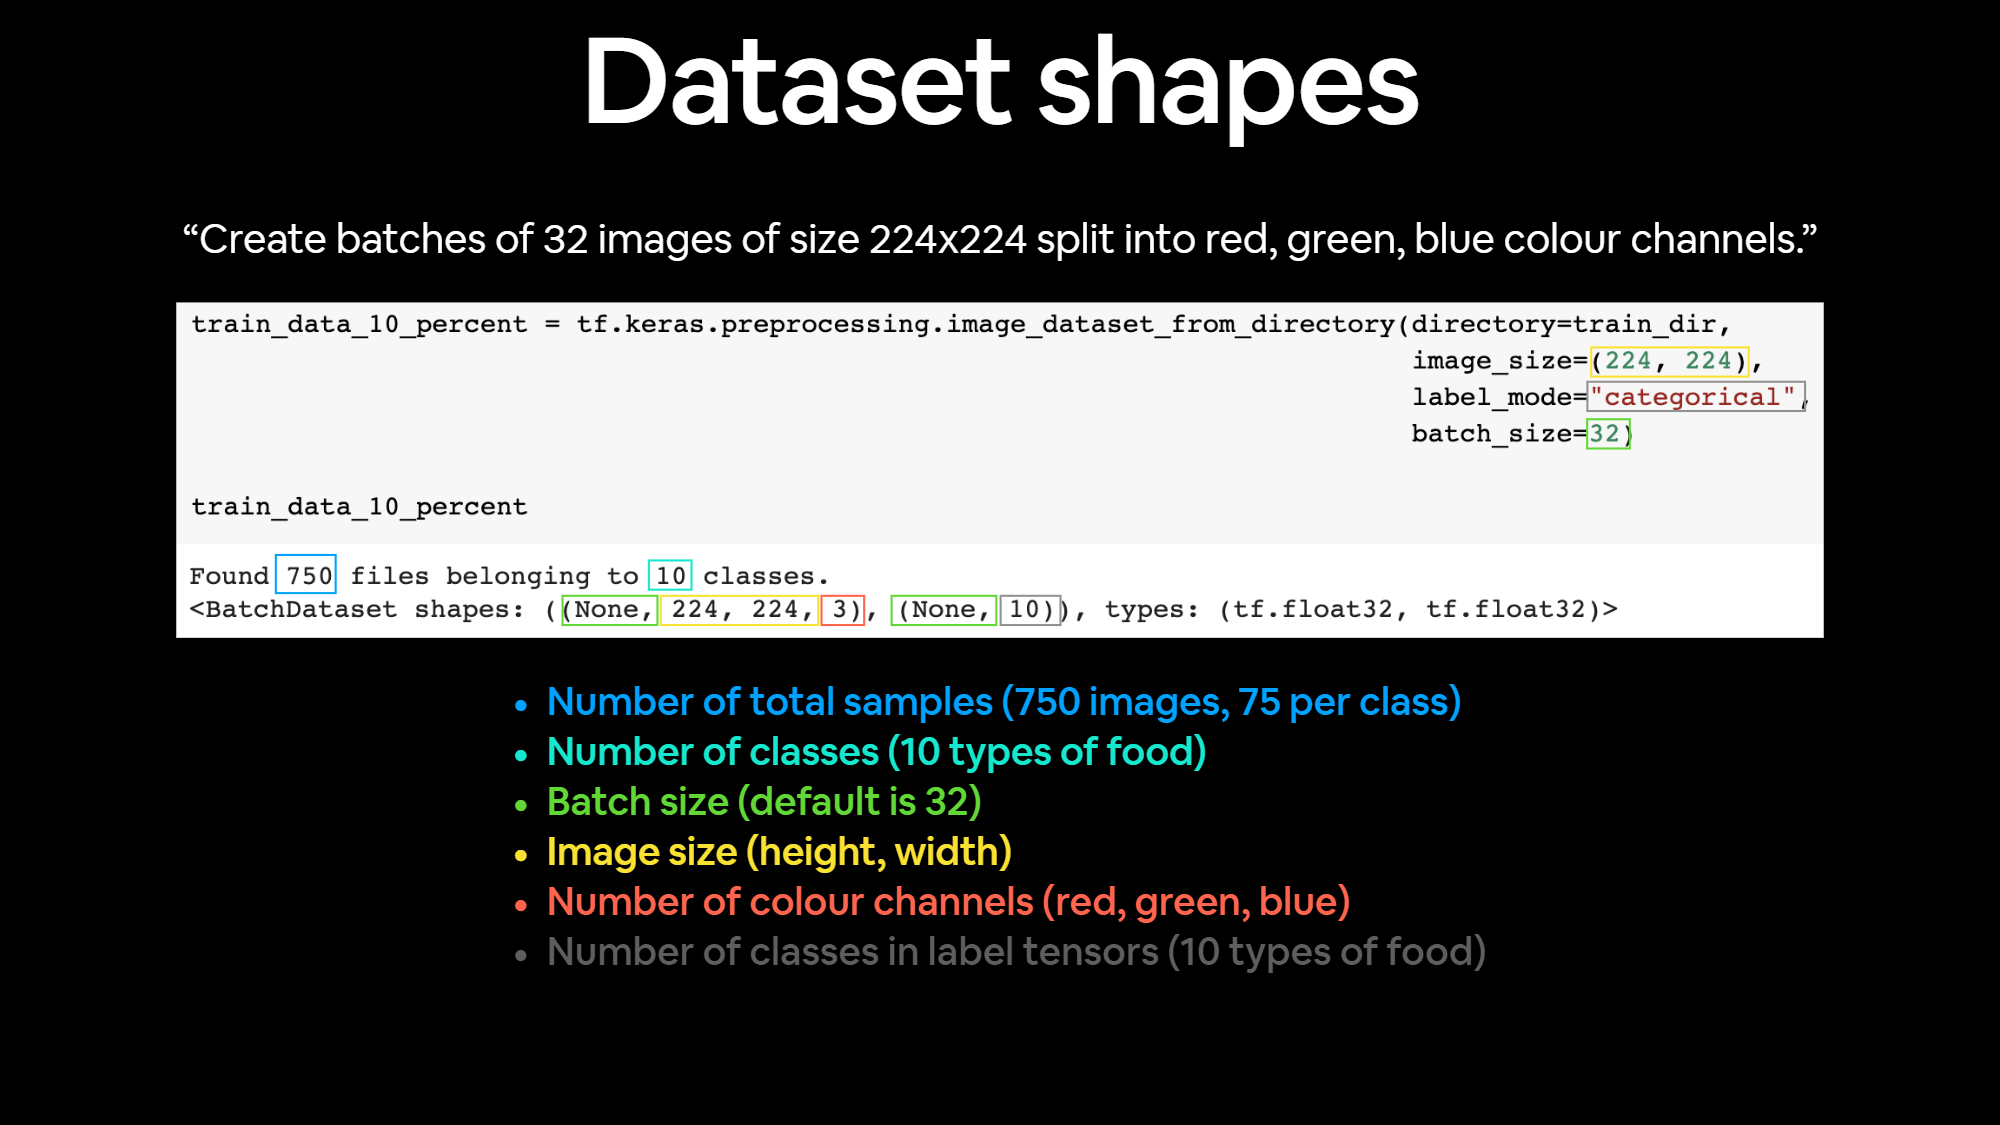

In [ ]:
# Check our class names of our dataset:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
# See an example of a batch of data:
#train_data_10_percent.take

for images, labels in train_data_10_percent.take(1): # 1 because we take one batch. And when teh batch is gotten, then it will be in the following order: images, and labels
  print(images, labels)


tf.Tensor(
[[[[ 78.71428    78.71428    54.714287 ]
   [ 78.331635   77.734695   55.525513 ]
   [ 78.14285    77.14285    57.57143  ]
   ...
   [ 93.07652    83.50505    73.29079  ]
   [ 96.096954   82.096954   73.096954 ]
   [101.48474    84.48474    76.48474  ]]

  [[ 81.02041    78.02551    55.357143 ]
   [ 79.         77.         56.       ]
   [ 77.372444   74.602036   57.872448 ]
   ...
   [ 95.51535    83.15814    73.94388  ]
   [ 97.86224    83.86224    74.86224  ]
   [100.95409    83.95409    75.95409  ]]

  [[ 84.21938    77.14285    58.142857 ]
   [ 81.85714    76.71429    57.785713 ]
   [ 79.90816    76.188774   62.       ]
   ...
   [ 99.57147    85.90817    74.73982  ]
   [101.198975   87.198975   76.198975 ]
   [101.49489    85.13775    75.352036 ]]

  ...

  [[119.79087   116.500084  109.862366 ]
   [126.28036   123.05079   115.780426 ]
   [130.84691   127.58673   120.63269  ]
   ...
   [109.69392   124.47965   165.05113  ]
   [108.086685  122.87242   163.4439   ]
   [1

**Observation** The range of the images numbers are not binary, so we might have to normalize it later!

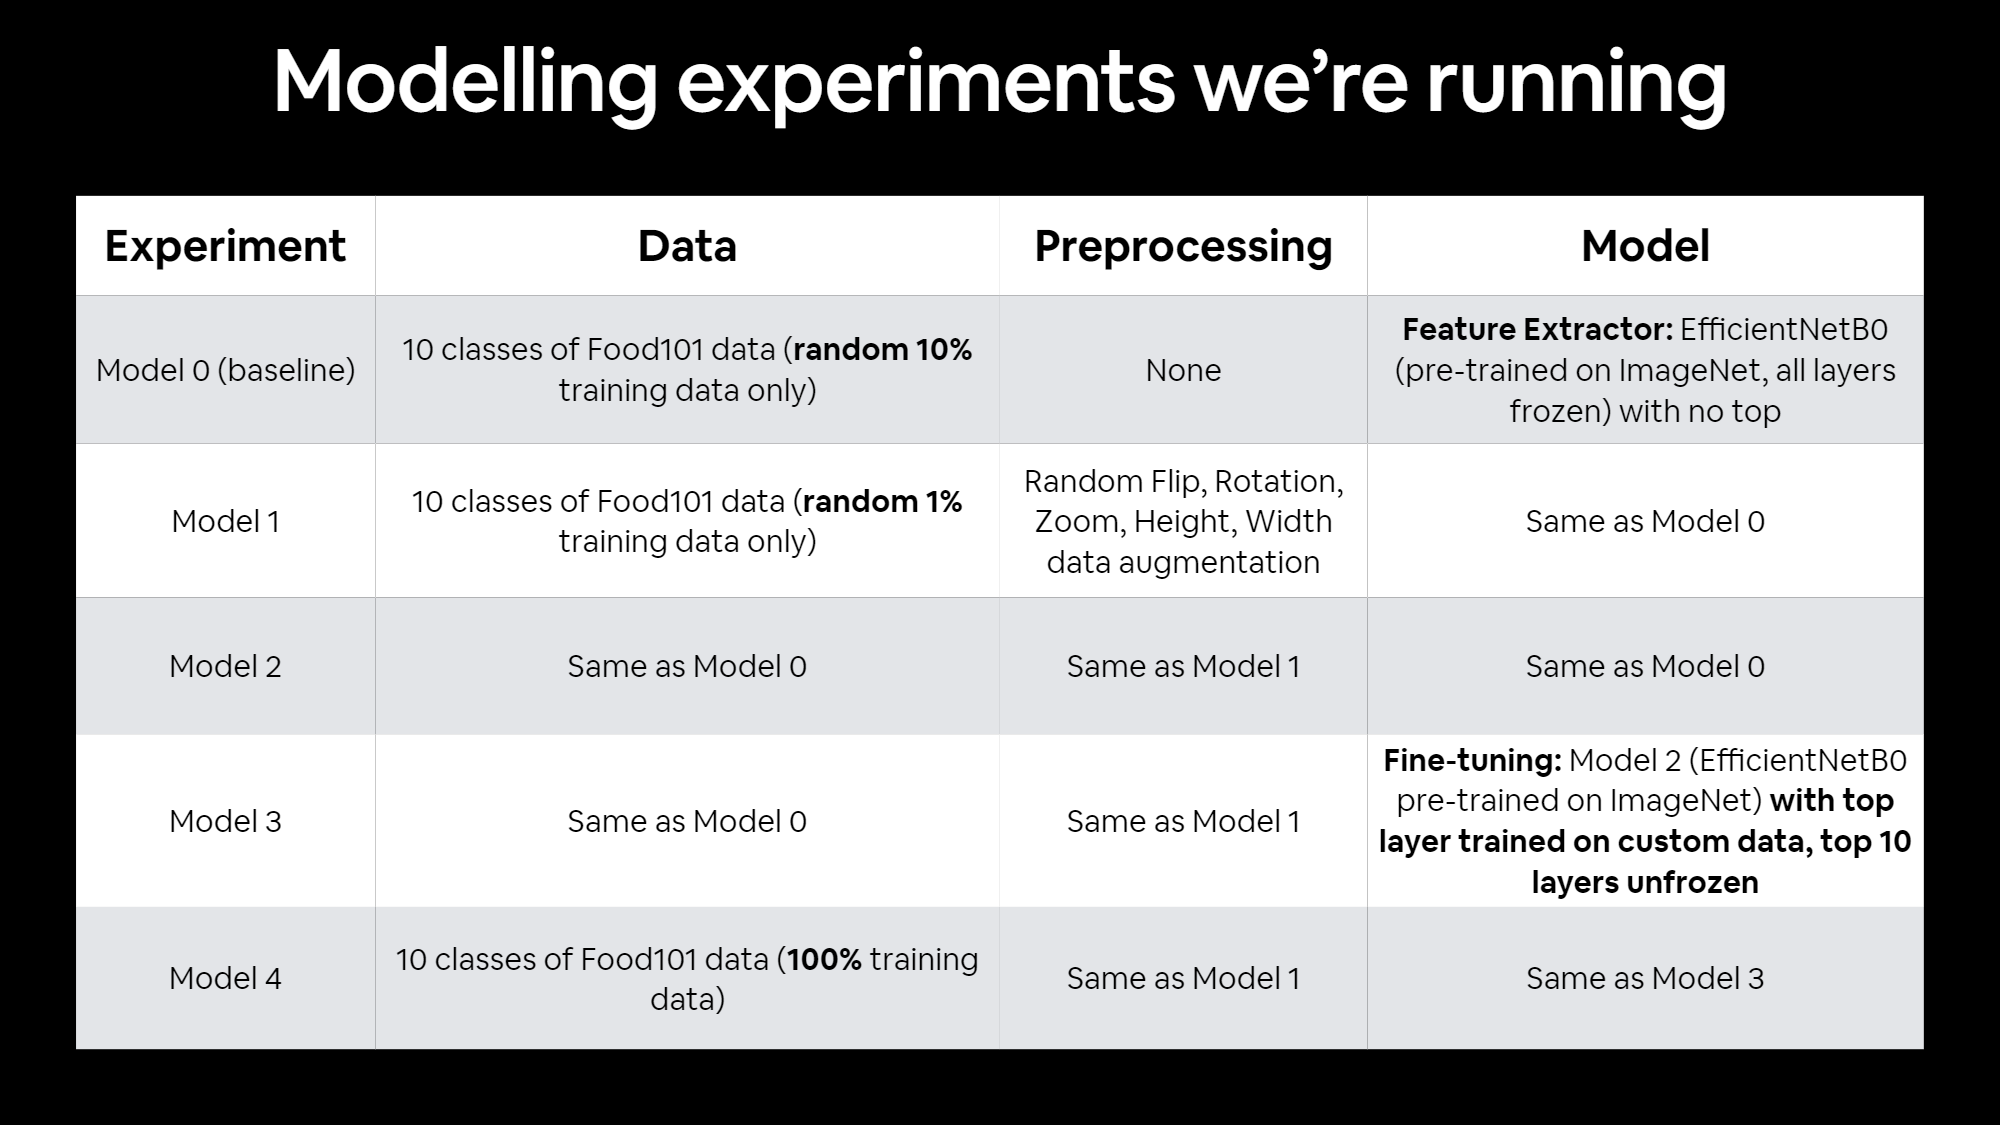

# Using the Keras Functional API INSTEAD OF the regular Kera's Sequential API:  

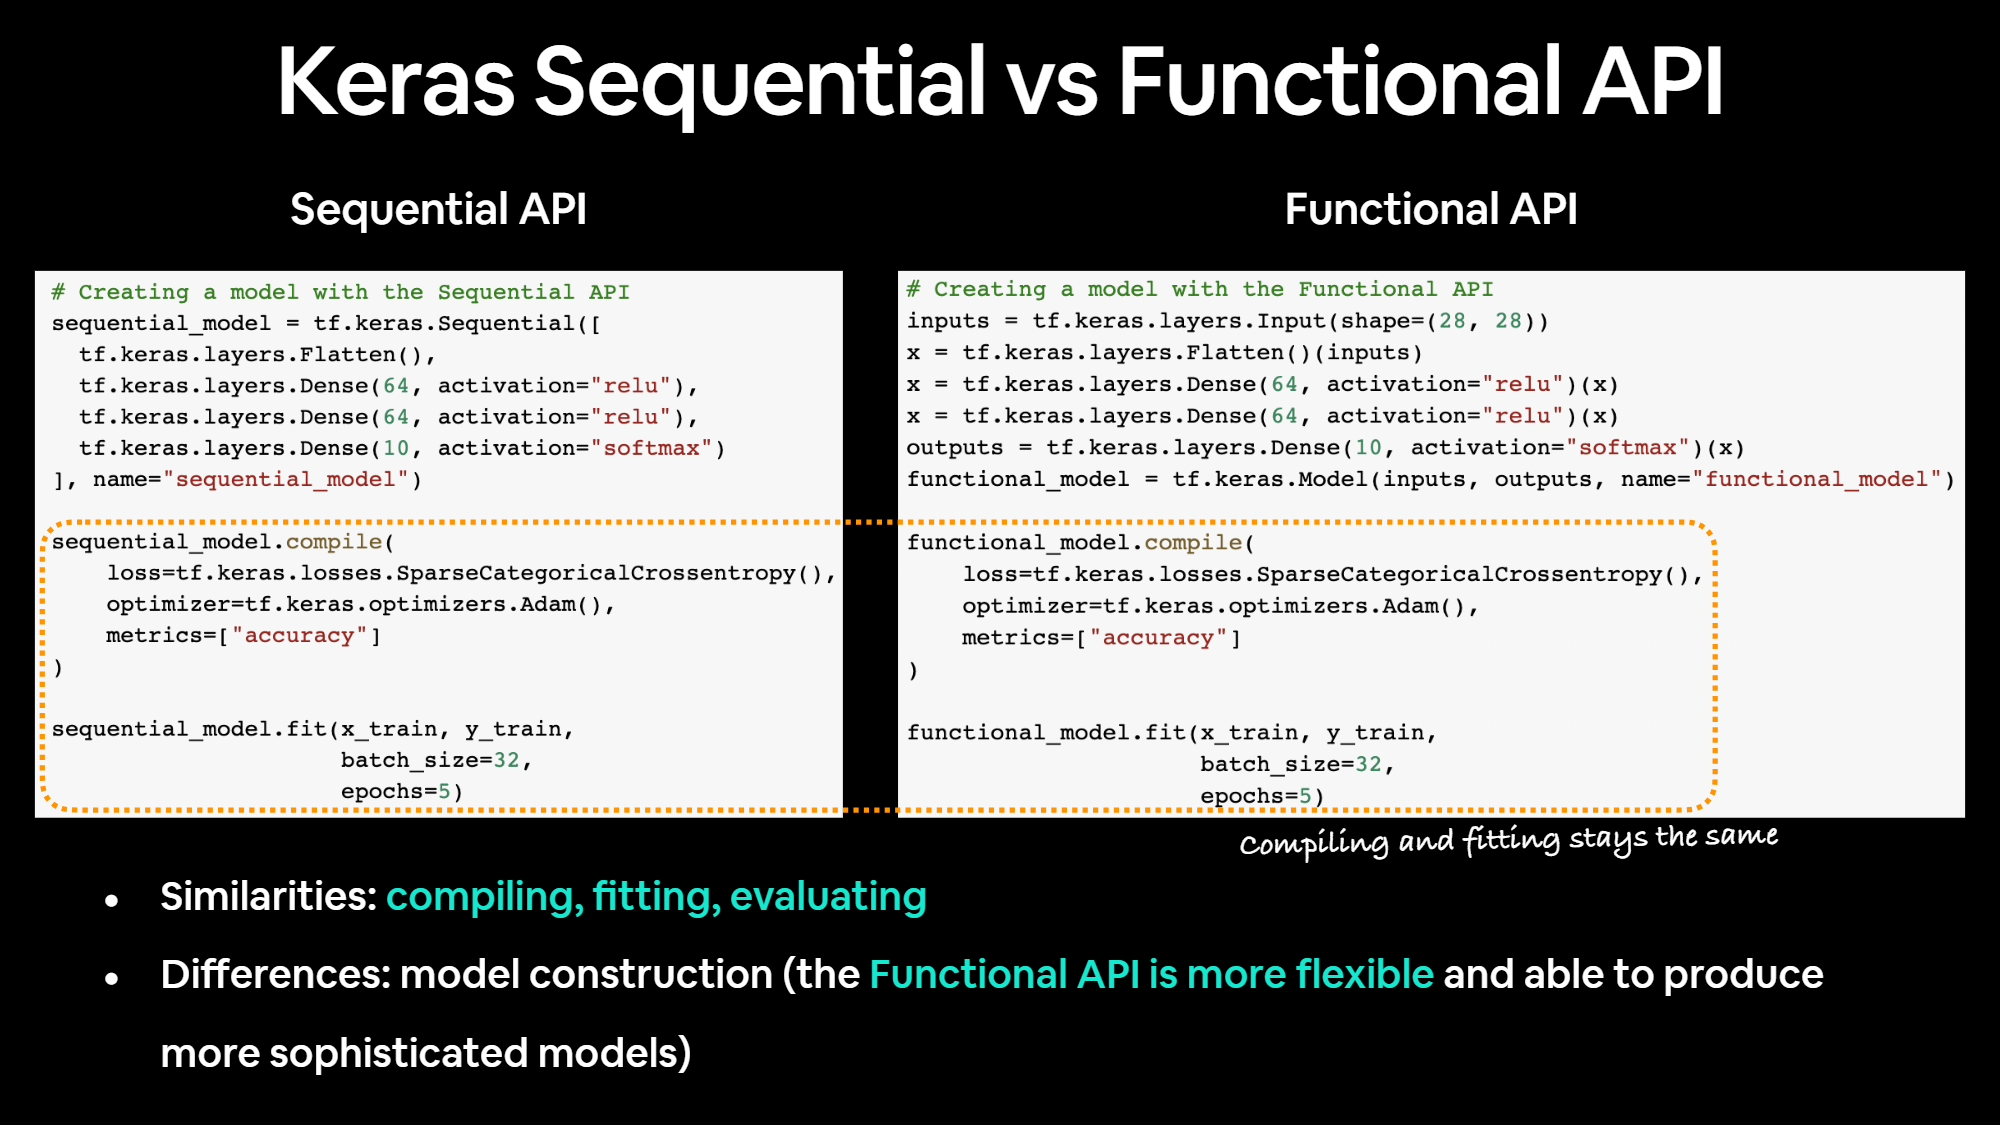

# Model 0: Build a transfer learning feature extraction model using the Keras Functional API:

* The Sequential API is straight-forward, it runs our layers in a sequential order.
* The Functional API gives us more lfexibility with our models.

In [ ]:
# Try building a model using the tf.keras.applications modules:
# Read documentation: https://www.tensorflow.org/api_docs/python/tf/keras/applications

# Create model:
base_model = tf.keras.applications.EfficientNetB0(include_top = False)

# 2. Freeze the base model (the underlying pre-trained patterns are not updated during training)
base_model.trainable = False

# 3. Create inputs into our model:
inputs = tf.keras.layers.Input(shape = (224, 224, 3),
                               name = 'input_layer')

# 4. IF using a model like ResNet50V2, we need to NORMALIZE inputs: (NO NEED TO NORALIZE FOR: EfficientNet(s))!!!!!!!
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255) (inputs) ### Pros of using Functional API -> We can normalize data into our model!

# 5. Pass inputs to base model:
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important info AND reduce number of computations):
x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the outputs activation layer:
outputs = tf.keras.layers.Dense(10, activation = 'softmax', name = 'output_layer')(x)

# 8. Combine inputs with outputs into a model:
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile model_0:
model_0.compile(loss = tf.keras.losses.categorical_crossentropy, ### IMPORTANT: USE -> categorical_crossentropy NOT CategoricalCrossentropy !!!
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

# 10. Fit model_0 AND save its history:
history_10_percent = model_0.fit(train_data_10_percent,
                      epochs = 5,
                      steps_per_epoch = len(train_data_10_percent),
                      validation_data = test_data_10_percent,
                      validation_steps =int(0.25*len(test_data_10_percent)), # This only validates 25% of all the test data, so for this experiment it fits faster!
                      callbacks = [create_tensorboard_callback(dir_name = "transfer_learning",
                                                               experiment_name = "10_percent_feature_extraction")])

16705208/16705208 [==============================] - 1s 0us/step


Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20230720-054558
Epoch 1/5
24/24 [==============================] - 24s 241ms/step - loss: 1.8614 - accuracy: 0.4387 - val_loss: 1.2730 - val_accuracy: 0.7632
Epoch 2/5
24/24 [==============================] - 3s 121ms/step - loss: 1.0772 - accuracy: 0.7773 - val_loss: 0.8534 - val_accuracy: 0.8339
Epoch 3/5
24/24 [==============================] - 3s 119ms/step - loss: 0.7733 - accuracy: 0.8333 - val_loss: 0.6955 - val_accuracy: 0.8454
Epoch 4/5
24/24 [==============================] - 3s 122ms/step - loss: 0.6254 - accuracy: 0.8627 - val_loss: 0.6126 - val_accuracy: 0.8569
Epoch 5/5
24/24 [==============================] - 3s 120ms/step - loss: 0.5348 - accuracy: 0.8920 - val_loss: 0.5599 - val_accuracy: 0.8668


In [ ]:
# Evaluate on the full test dataset instead of just 25% of it:
model_0.evaluate(test_data_10_percent)

79/79 [==============================] - 6s 67ms/step - loss: 0.5496 - accuracy: 0.8676


[0.5496454834938049, 0.8676000237464905]

In [ ]:
# Check the layers in our base model, which is the "EfficientNetB0" used above:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activation
5

In [ ]:
# Getting a summary of the base model:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [ ]:
# Now a summary of our whole mode:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


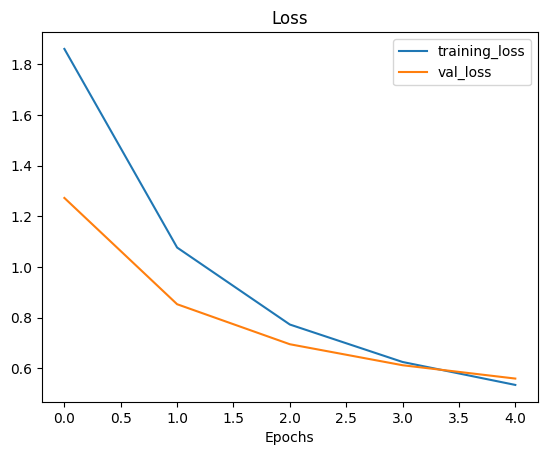

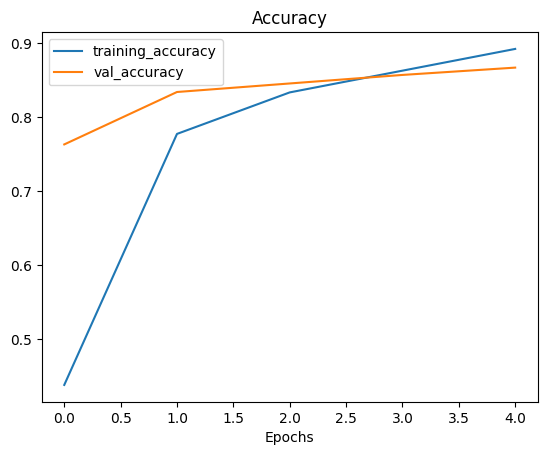

In [ ]:
# Checking out model_0's training curves:
plot_loss_curves(history_10_percent)

# Getting a feature vector from a trained model:

Let's demostrate the Global Average Pooling 2D layer...
* Documentation: https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280).

But then when it passes through GlobalAveragePooling2D, it turns into (None, 1280).

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D

**Basically, GlobalAveragePoolinng2D transforms a 4D tensor into a 2D tensor!**

In [ ]:
# Defining input shape:
input_shape = (1, 4, 4, 3) # We're using this shape instead of the one we got from our model (None, 7, 7, 1280), so it's easrier to visualize! The only thing is we need a tensor that is 4 dimenssions as well, which is why we're using this one (1, 4, 4, 3)

# Create a random tensor:
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor: \n {input_tensor} \n")

# Pass the random tensor through a global average poolingn 2D layer:
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor) # We're passing the input_tensor after the layer
print(f"2D global average pooled random tensor: \n {global_average_pooled_tensor} \n")

# Check the shape of the different tensors:
print(f"Shape of input tensor: {input_tensor.shape}") # Remember: Add shape to the tensor name!
print(f"Shape of Global Average Pooled 2D tensor: {global_average_pooled_tensor.shape}")# Remember: Add shape to the tensor name!


Random input tensor: 
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]] 

2D global average pooled random tensor: 
 [[-0.09368646 -0.45840448 -0.2885598 ]] 

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor: (1, 3)


In [ ]:
###########################################################
### Let's replicate the Global Average Pooled 2D Layer: ###
###########################################################

# This does the same as the Global Average Pooled 2D Layer:
tf.reduce_mean(input_tensor, axis = [1, 2]) # This means: Reduce the input tensor to the mean of the input values accross the axis 1 qnd 2 (since in python the first one is zero 1 & 2 are: 4, 4, since -->> (1, 4, 4, 3))


<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

**PRACTICE** Try to do the same as the above 2 cells (`GlobalAveragePooling2D` layer), but this time use `GlobalMAxPool2D` layer instead, and see what happens!   

In [ ]:
# Using GlobalMaxPool2D layer:

# Define input shape:
input_shape_max = (1, 4, 4, 3)

# Set random seed and create random tensor:
tf.random.set_seed(42)
input_tensor_2 = tf.random.normal(input_shape_max)
print(f"Random input tensor: {input_tensor_2}")

# Pass the random tensor through a Global Max Pool 2D layer:
global_max_pooled_tensor = tf.keras.layers.GlobalMaxPooling2D()(input_tensor_2)
print(f" \n 2D global max pooled layer: \n {global_max_pooled_tensor} \n")

# Checking the shape of both tensors:
print(f"Shape of Random input tensor (4D): {input_tensor_2.shape}")
print(f"Shape of GlobalMaxPooling2D tensor (2D): {global_max_pooled_tensor.shape}")

Random input tensor: [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]
 
 2D global max pooled layer: 
 [[0.9058464 1.1603122 1.6994323]] 

Shape of Random input tensor (4D): (1, 4, 4, 3)
Shape of GlobalMaxPooling2D tensor (2D): (1, 3)


**NOTE:** ON eof the reasons why feature extraction is named this way is because often, pretrained models output a feature vector, a long tensorf of numbers that represnet the learned representation of the model, on a particular sample. In this case, this output of the tf.keras.`GlobalAveragePooling2D()` / `GlobalMaxPooling2D` layer, which can then be used to extract patterns out of our own specific problems (datasets).

## Running a series of Transfer Learning Experiments

We've seen the incredible results Transfer Learning can get with only 10% of the training data, BUT how does it go with 1% of the training data?
* Let's set up several experiments to find out:
1. `model_1` - Use **Feature Extraction** Transfer Learning with **1%** of the training data with **Data Augmentation**.
2. `model_2` - Use **Feature extraction** Transfer Learning with **10%** of the training data with **Data Augmentation**.
3. `model_3` - Use **Fine-Tuning** transfer learning on **10%** of the training data with **Data Augmentation**.
4. `model_4` - Use **Fine-Tuning** transfer learningon **100%** of the training data with **Data Augmentation**.

**NOTE:** Throughout all experiments, the same test dataset will be used to evaluate our model. This ensures consistency accross all evaluation metrics.



## Getting AND Pre-processing data from model_1

In [ ]:
# Downloading and Unzip data - pre-processed from Food101:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2023-07-20 05:46:48--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.97.128, 142.250.157.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  30.5MB/s    in 5.0s    

2023-07-20 05:46:54 (25.4 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:
# Create training and test directories (dir):
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir_1_percent = "10_food_classes_1_percent/test"

In [ ]:
### Inspect how many images we're working with: ###

# Using funciton from helper_functions
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There a

In [ ]:
# Set up data loaders:
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode = 'categorical',
                                                                           image_size = IMG_SIZE,
                                                                           batch_size = BATCH_SIZE) # Default is 32 # We have set up a global variable for BATCH_SIZE = 32 before

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = 'categorical',
                                                                image_size = IMG_SIZE,
                                                                batch_size = BATCH_SIZE)


Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
print(tf.__version__)

2.12.0


# Adding Data Augmentation:

To add Data Augmentation right into our models, we can use the layers inside:

* `tf.keras.layers.experimental.preprocessing()`

* Documentataion: https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing

We can see the benefits of doing this within TensorFlow Data Augmentation: https://www.tensorflow.org/tutorials/images/data_augmentation#use_keras_preprocessing_layers

Off the top of our heads, after reading the docs, the pros of using Data Augmentation inside the model are:
* Preprocessing of images (aumenting them) happens on the GPU rather than CPU, which is much faster.
* Image data augmentation only happens during training, so we can still export our model and export it elsewhere. This means that data augmentation is only turned on during training.


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Creating data augmentation stage with horizontal flipping, rotations, zooms...
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocessing.Rescaling(1./255) ### Keep for models such as ResNet50V2, but EfficientNet have rescaling built-in, so we don't need it here!


], name = "data_augmentation")


# Visualizing our Data Augmentation layer to see what happens to our data

In [ ]:
train_data_1_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

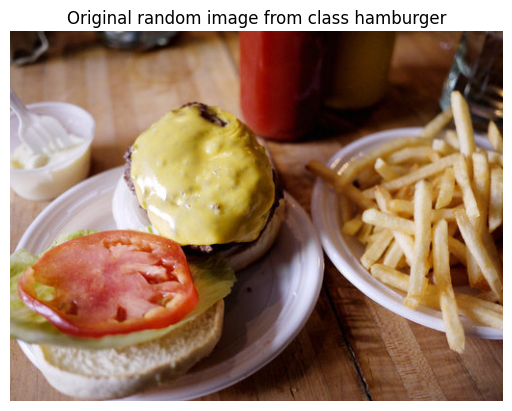

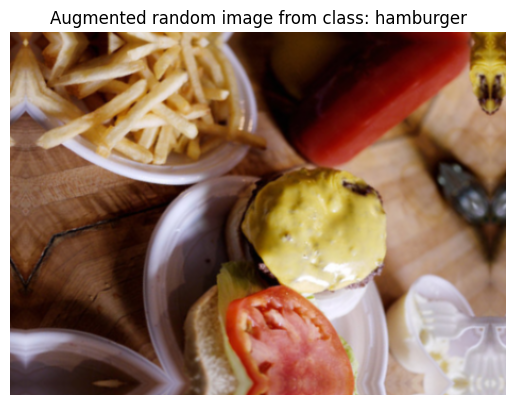

In [ ]:
# View a random image and compare it to its augmented version:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)   # Choosing a random class
target_dir = "10_food_classes_1_percent/train/" + target_class   # Creating the target directory
random_image = random.choice(os.listdir(target_dir))             # Choosing a random image from the target directory defined above
random_image_path = target_dir + "/" + random_image              # Creating the chosen random image path

# Read in the random image:
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class {target_class}")
plt.axis(False);
# print(target_dir)
# print(random_image_path)
# print(img)

# Now let's plot our augmented random image:
augmented_img = data_augmentation(tf.expand_dims(img, axis = 0)) # The "data_augmentation" model has been created in the cell above!
plt.figure() ### WE MUST CREATE A NEW FIGURE SINCE WE HAVE ALREADY CALLED ONE BEFORE!!! ###
plt.imshow(tf.squeeze(augmented_img)/255.)                       # We need to add normalization after augmentation!
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

## Model 1: Feature extraction transfer learning on 1% of the data with data augentation

In [ ]:
IMG_SIZE + (3,) # IMG_SIZE was defined before!

(224, 224, 3)

In [ ]:
# Setup input shape and base model, freezing the base model layers:
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False                                            # Since we're only doing feature extraction and this model has been trained on ImageNet, we don't want to train this part and leave it as it is!

# Create input layer:
inputs = layers.Input(shape = input_shape, name = "input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs) ### ONLY ON THE TRAINING DATA!!! ###

# Give base model the inputs after they've been augmented and don't train it!
x = base_model(x, training = False)

# Pool output features of the base model:
x = layers.GlobalAveragePooling2D()(x)

# Put a dense layer on as the output:
outputs = layers.Dense(10, activation = "softmax", name = "output_layer")(x)

# Make a model using the inputs and outputs:
model_1 = keras.Model(inputs, outputs)

# Compile model:
model_1.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

# Fit model:
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs = 5,
                                steps_per_epoch = len(train_data_1_percent),
                                validation_data = test_data,
                                validation_steps = int(0.25 * len(test_data)),
                                # Track model training logs:
                                callbacks = [create_tensorboard_callback(dir_name = "transfer_learning",
                                                                         experiment_name = "1_percent_data_aug")])


Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20230720-054700
Epoch 1/5
3/3 [==============================] - 13s 2s/step - loss: 2.2091 - accuracy: 0.2143 - val_loss: 2.1424 - val_accuracy: 0.2286
Epoch 2/5
3/3 [==============================] - 3s 1s/step - loss: 2.0211 - accuracy: 0.2857 - val_loss: 2.0236 - val_accuracy: 0.3240
Epoch 3/5
3/3 [==============================] - 3s 1s/step - loss: 1.7939 - accuracy: 0.4143 - val_loss: 1.9309 - val_accuracy: 0.3684
Epoch 4/5
3/3 [==============================] - 3s 1s/step - loss: 1.6277 - accuracy: 0.6286 - val_loss: 1.8254 - val_accuracy: 0.4556
Epoch 5/5
3/3 [==============================] - 3s 1s/step - loss: 1.5054 - accuracy: 0.7143 - val_loss: 1.7243 - val_accuracy: 0.5296


In [ ]:
# Checking out model_1 summary:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [ ]:
# Evaluate on the full dataset:
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 5s 60ms/step - loss: 1.7179 - accuracy: 0.5100


[1.717875361442566, 0.5099999904632568]

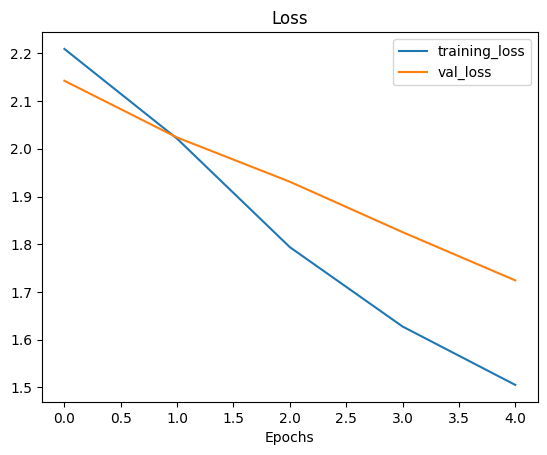

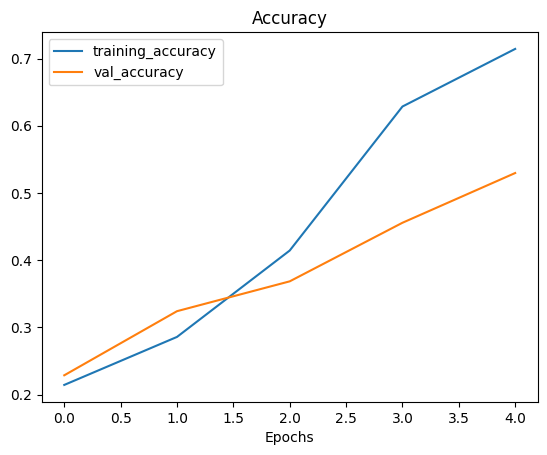

In [ ]:
# Checking loss curves to see how does the model with 1% of the data perform with data augmentation:
plot_loss_curves(history_1_percent)

## Model 2: Feature extraction transfer learning model with 10% of data and data augmentation:

In [ ]:
### Get 10% of data:### (UNCOMENT IF WE DON'T HAVE IT IMPORTED. BUT THIS WAS IMPORTED AT THE BEGINING)

# !wget "https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip"
# unzip_data(10_food_classes_10_percent)

train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [ ]:
# Setup data inputs:
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode = 'categorical',
                                                                            image_size = IMG_SIZE) # This time we only set up image size, no need to set up batch size since the default one is 32, and this works for now!

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = 'categorical',
                                                                image_size = IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# Checking how many images there are in our directories:
walk_through_dir("10_food_classes_10_percent")


There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [ ]:
from keras.api._v2.keras.layers import RandomRotation
# Create model 2 with data augmentation built-in:
from tensorflow.keras import layers
# from tensorflow.keras.layers.experimental import preprocessing --> Needed for older versiona of Tensorflow, but not anymore!
from tensorflow.keras.models import Sequential # This one is needed for our augmentation layers

# Build data augmentation layer:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomZoom(0.2),
    layers.RandomRotation(0.2),
    # preprocessing.Rescaling(1./255) ### No need to use it with EfficientNet, since it's already built-in, but when using other models such as ResNet50V2, we need to inlude this here!
], name = "data_augmentation")

# Setup the input shape to our model:
input_shape = (224, 224, 3)

# Create a frozen base model (also called the Backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

# Create inputs and outputs (inlcuding the layers in between)
inputs = layers.Input(shape = input_shape, name = "input_layer")
x = data_augmentation(inputs) # Augment our training images (augmentation doesn't occur on test data!!!)
x = base_model(x, training = False) # Passsing augmented images to the base model. But, keep base model in inference mode (all layers in base model don't get their weights updated). This also ensures batchnorm layers don't get updated.
x = layers.GlobalAveragePooling2D(name = "global_average_pooling_2D")(x) # NOTE: If it's a layer (like this one), then x goes outside, but if its a model like the line above, then x goes inside!
outputs = layers.Dense(10, activation = "softmax", name = "output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile model:
model_2.compile(loss = "categorical_crossentropy", ### REMBER: Make sure to type it like this: loss = "categorical_crossentropy" NOT like this: loss = tf.keras.losses.CategoricalCrossentropy
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])


In [ ]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_2D (  (None, 1280)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

# Creating a model checkpoint callback

Documentation link: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

The ModelCheckPoint callback intermediately saves our model (the full model or just the weights) during training. This is useful so we can come and start where we left off.

In [ ]:
# Set checkpoint path # NOTE: TO SAVE our model checkpoints, we need a path!!!
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckPoint callback that saves the model's weights only: (instead of saving the whole model, since this way (weights only) makes it faster)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                         save_weights_only = True,
                                                         save_best_only = True,
                                                         save_freq = "epoch", # It saves every epoch, thanks to this frequency!
                                                         verbose = 1) # Save every epoch


# Fit model_2 in the ModelCheckpoint callback

In [ ]:
# Fit the model saving checkpoints every epoch:
initial_epochs = 5

# NOW fit model_2 on 10 % of the train data AND pass the checkpoint callback:
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs = initial_epochs,
                                          # steps_per_epoch = len(train_data_10_percent),
                                          validation_data = test_data,
                                          validation_steps = int(0.25 * len(test_data)),
                                          callbacks = [create_tensorboard_callback(dir_name = "transfer_learning",
                                                                                   experiment_name = "10_percent_data_aug"),
                                                       checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20230720-054734
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0173 - accuracy: 0.3253
Epoch 1: val_loss improved from inf to 1.45003, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 22s 641ms/step - loss: 2.0173 - accuracy: 0.3253 - val_loss: 1.4500 - val_accuracy: 0.6727
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3279 - accuracy: 0.6880
Epoch 2: val_loss improved from 1.45003 to 1.01286, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 12s 483ms/step - loss: 1.3279 - accuracy: 0.6880 - val_loss: 1.0129 - val_accuracy: 0.7895
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0060 - accuracy: 0.7600
Epoch 3: val_loss improved from 1.01286 to 0.78990, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [=

In [ ]:
# Viewing model_0 results again, to compare them with mdoel_2:
model_0.evaluate(test_data)

79/79 [==============================] - 6s 60ms/step - loss: 0.5496 - accuracy: 0.8676


[0.5496454834938049, 0.8676000237464905]

In [ ]:
# Check model_2 results on all the test data instead of just 20% like we did before:
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 5s 60ms/step - loss: 0.6307 - accuracy: 0.8328


[0.6307225823402405, 0.8327999711036682]

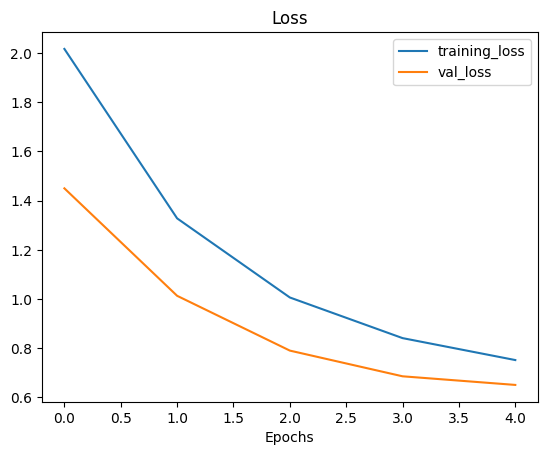

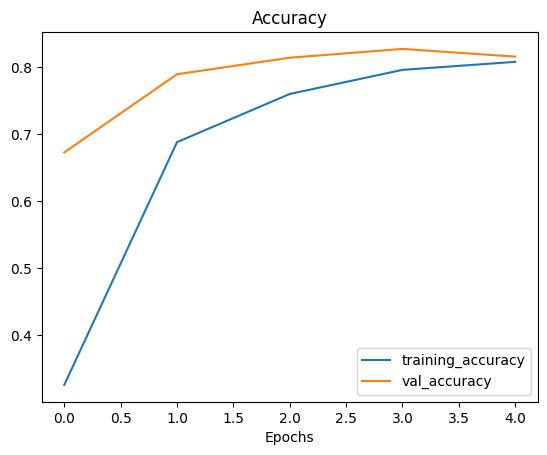

In [ ]:
# Plotting model_2 loss curves:
plot_loss_curves(history_10_percent_data_aug) # These loss curves are really good, and are pointing to the right direction. So if we kept training the mode for longer it might perform better


### Loading in checkpointed weights

Loading checkpointed weights returns a model to a specific checkpoint

In [ ]:
# Load in saved model weights and evaluate model: The results should be the same as model_2's!!!
model_2.load_weights(checkpoint_path)

In [ ]:
# Evaluate model_2 with loaded weights:
loaded_weights_model_results = model_2.evaluate(test_data)


79/79 [==============================] - 5s 60ms/step - loss: 0.6307 - accuracy: 0.8328


In [ ]:
# If the results from the previously evaluated model_2 match the loaded weights, everything has worked well!
results_10_percent_data_aug == loaded_weights_model_results

False

In [ ]:
# Check if the loaded model results are very close to our previous non-loaded model results:

import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [ ]:
######################################################################
### The difference is very small, so we can consider them the same ###
######################################################################

# Checking the difference between the two results:
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[1.1920929e-07 0.0000000e+00]


# Model 3: Fine-tuning an existing model on 10% of the data

**NOTE:** Fine-tuning usually works best after a feature extraction model for a few epochs with large amounts of custom data.

In [ ]:
# Check our layers in our loeaded model:
model_2.layers

In [ ]:
# Are these layers trainable?
for layer in model_2.layers:
  print(layer, layer.trainable) ### As seen, the Functional layer is frozen!!! ###

<keras.engine.input_layer.InputLayer object at 0x7bc7c97ccfa0> True
<keras.engine.sequential.Sequential object at 0x7bc7bd7f20b0> True
<keras.engine.functional.Functional object at 0x7bc7bd6bb0a0> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7bc7bd49b730> True
<keras.layers.core.dense.Dense object at 0x7bc7bd72b970> True


In [ ]:
# What layers are in our base model (EfficientNetB0) and are they trainable?:
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [ ]:
# How many trainable variables are in our base model?
print(len(model_2.layers[0].trainable_variables))

0


In [ ]:
# To begin fine-tuning, let's start by setting the last 10 layers of our base_model.trainable = True
base_model.trainable = True

# Freeze all layers except for the last 10:
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile (We must recompile our models every time a change is made)
model_2.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), # Since we don't want the already trained layers to re-learn patterns too much, we normally set the learning rate 10X lower (0.0001, in this case)
                metrics = ['accuracy'])



**NOTE:** When using Fine-Tuning is best to lower the Learning-Rate by some amount. This hyperparameter is tunable, but normally lowering by 10X is the way to go.

A good resource to understand it further: https://arxiv.org/abs/1801.06146

In [ ]:
# Check which layers are tunable (trainable):
for layer_number, layer in enumerate(base_model.layers): # Same as model_2.layers[2] IMPORTANT: getting layer[2] from model_2, because that's the base model
  print(layer_number, layer.name, layer.trainable)


0 input_3 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [ ]:
# Now, after unfrozing some of the layers, let's check how many are still trainable:
print(len(model_2.trainable_variables))

12


In [ ]:
model_2.trainable_variables

[<tf.Variable 'block7a_se_reduce/kernel:0' shape=(1, 1, 1152, 48) dtype=float32, numpy=
 array([[[[-0.05485657,  0.07178846,  0.01534605, ..., -0.09284662,
            0.0104828 , -0.02693838],
          [-0.03157939,  0.02819107, -0.05579546, ...,  0.00487578,
            0.12001809, -0.06901816],
          [-0.07792544,  0.12601745,  0.03935236, ...,  0.03086486,
           -0.01581392,  0.1306234 ],
          ...,
          [-0.07692936,  0.19920062,  0.17471024, ...,  0.03312391,
           -0.04528928, -0.09214652],
          [ 0.01010198,  0.06855008,  0.05820991, ...,  0.00131649,
           -0.08952942, -0.00476829],
          [ 0.03583075, -0.01228165,  0.04561347, ..., -0.00822134,
           -0.07354517, -0.06507882]]]], dtype=float32)>,
 <tf.Variable 'block7a_se_reduce/bias:0' shape=(48,) dtype=float32, numpy=
 array([-0.10886215, -0.13624744, -0.15257476,  0.14799541, -0.08512902,
        -0.12059905, -0.08779966, -0.08187538, -0.06925284, -0.12518929,
        -0.0819265 ,

In [ ]:
# Fine-tune for another 5 epochs:
fine_tune_epochs = initial_epochs + 5

# Re-fit the model (same as model_2 except with more trainable layers):
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs = fine_tune_epochs,
                                               validation_data = test_data,
                                               validation_steps = int(0.25 * len(test_data)),
                                               initial_epoch = history_10_percent_data_aug.epoch[-1],  # Starting off at the last epoch where model_2 left of
                                               callbacks = [create_tensorboard_callback(dir_name = "transfer_learning",
                                                                                        experiment_name = "10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20230720-054901
Epoch 5/10
24/24 [==============================] - 24s 551ms/step - loss: 0.6310 - accuracy: 0.8160 - val_loss: 0.4793 - val_accuracy: 0.8454
Epoch 6/10
24/24 [==============================] - 9s 378ms/step - loss: 0.5078 - accuracy: 0.8440 - val_loss: 0.4815 - val_accuracy: 0.8421
Epoch 7/10
24/24 [==============================] - 9s 371ms/step - loss: 0.4290 - accuracy: 0.8693 - val_loss: 0.4442 - val_accuracy: 0.8487
Epoch 8/10
24/24 [==============================] - 9s 399ms/step - loss: 0.3923 - accuracy: 0.8773 - val_loss: 0.4392 - val_accuracy: 0.8635
Epoch 9/10
24/24 [==============================] - 9s 351ms/step - loss: 0.3634 - accuracy: 0.8827 - val_loss: 0.4189 - val_accuracy: 0.8684
Epoch 10/10
24/24 [==============================] - 10s 381ms/step - loss: 0.3177 - accuracy: 0.9000 - val_loss: 0.4581 - val_accuracy: 0.8454


In [ ]:
# Evaluate the fine-tuned model (model_3 (which is actually model_2 fine-tuned for another 5 epochs))
results_fine_tuned_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 5s 62ms/step - loss: 0.4251 - accuracy: 0.8528


In [ ]:
results_10_percent_data_aug

[0.6307225823402405, 0.8327999711036682]

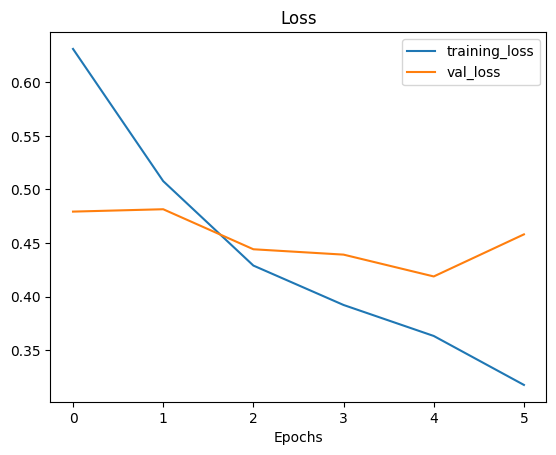

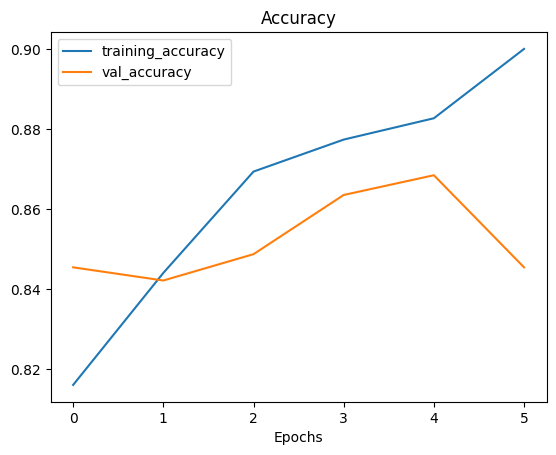

In [ ]:
# Plotting loss curves:
plot_loss_curves(history_fine_10_percent_data_aug)

**NOTE:** The `plot_loss_curves` function works well with models that have only been fit once, however, in this case (fine-tuning) we need to compare one series of running `fit()` with another (i.e. before and after fine-tuning).

In [ ]:
# Creating a function to compare training histories:
def compare_historys(original_history, new_history, initial_epochs = 5):
  """
  Compares two TensorFlow history objects.
  """
  # Getting original history measurements:
  acc = original_history.history['accuracy']
  loss = original_history.history['loss']

  print(len(acc))

  val_acc = original_history.history['val_accuracy']
  val_loss = original_history.history['val_loss']

  # Combining original history metrics with new_history metrics:
  total_acc = acc + new_history.history['accuracy']
  total_loss = loss + new_history.history['loss']

  total_val_acc = val_acc + new_history.history['val_accuracy']
  total_val_loss = val_loss + new_history.history['val_loss']

  print(len(total_acc))
  print(total_acc)

  #####################################
  ### Plotting Loss and Acc curves: ###
  #####################################

  # Plotting Accuracy Curves:
  plt.figure(figsize = (8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label = "Training Accuracy")
  plt.plot(total_val_acc, label = "Val Accuracy")
  plt.plot([initial_epochs -1, initial_epochs -1],  # Set at epochs -1, because the graph is zero-indexed
           plt.ylim(), label = "Start Fine Tuning")
  plt.legend(loc = "lower right")
  plt.title("Training and Validation Accuracy")

  # Plotting Loss Curves:
  plt.figure(figsize = (8,8))
  plt.subplot(2, 1, 2)
  plt.plot(total_loss, label = "Training Loss")
  plt.plot(total_val_loss, label = "Val Loss")
  plt.plot([initial_epochs - 1, initial_epochs -1],
          plt.ylim(), label = "Start Fine Tuning")
  plt.legend(loc = "upper right")
  plt.title("Training and Validation Loss")

5
11
[0.3253333270549774, 0.6880000233650208, 0.7599999904632568, 0.7960000038146973, 0.8080000281333923, 0.8159999847412109, 0.843999981880188, 0.8693333268165588, 0.8773333430290222, 0.8826666474342346, 0.8999999761581421]


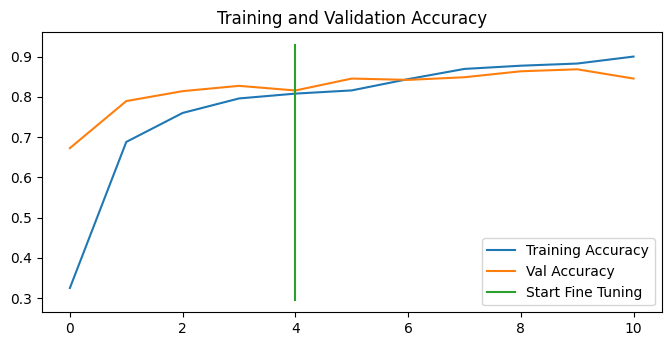

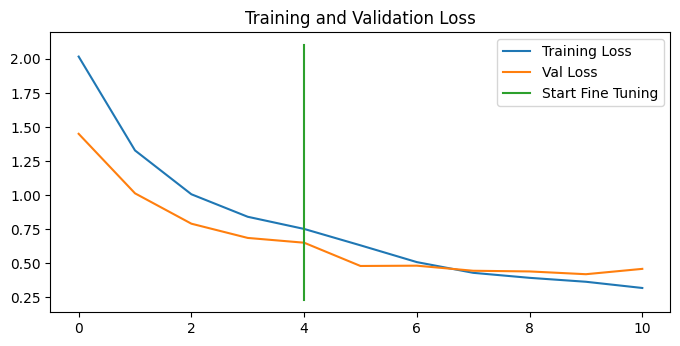

In [ ]:
compare_historys(history_10_percent_data_aug,
                  history_fine_10_percent_data_aug,
                  initial_epochs = 5)

In [ ]:
# Download and unzip 10 clases of Food101 data with all images:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

unzip_data('10_food_classes_all_data.zip')

--2023-07-20 05:50:20--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.187.128, 64.233.188.128, 64.233.189.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.187.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  28.5MB/s    in 18s     

2023-07-20 05:50:38 (27.8 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
# Setup training and test dir:
train_dir_all_data = '10_food_classes_all_data/train'
test_dir = '10_food_classes_all_data/test'

In [ ]:
# How many images are we working with now?
walk_through_dir('10_food_classes_all_data')

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.

In [ ]:
import tensorflow as tf

# Setup data inputs
IMG_SIZE = (224, 224)

train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                 label_mode = "categorical",
                                                                                 image_size = IMG_SIZE)

test_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                                label_mode = "categorical",
                                                                                image_size = IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test dataset we've loaded in is the same as what we've been using for previous experiments (all experiments have used the same test dataset)

But let's double check/verify this:

In [ ]:
# Evaluate model_2 (this is the fine-tuned 10% of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 5s 61ms/step - loss: 0.4251 - accuracy: 0.8528


[0.42506143450737, 0.8528000116348267]

In [ ]:
results_fine_tuned_10_percent

[0.42506143450737, 0.8528000116348267]

To train a fine-tuning model (model_4), we need to revert model_2 back to its feature extraction weigts.

In [ ]:
# Load weights from checkpoint. This way we can fine-tune from the
# same stage stage the 10 percent data model was fine-tuned from! ("comparing apples to apples")

# model_2.load_weights(checkpoint_path)

In [ ]:
# Evaluating model_2 now:
model_2.evaluate(test_data)

79/79 [==============================] - 5s 61ms/step - loss: 0.4251 - accuracy: 0.8528


[0.4250613749027252, 0.8528000116348267]

In [ ]:
# Check if our model_2 has been converted back to feature extraction results:
results_10_percent_data_aug

[0.6307225823402405, 0.8327999711036682]

Even though this might seen a bit confusing. All we've done is:

1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data with data augmentation (model_2). AND we've saved the model's weights using `ModelCheckpoint` callback.
2. Then we fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen (model_3).
3. Saved the results and training logs each time.
4. Reloaded the model from step 1 to do the same steps as step 2, but this time we'll use **ALL THE DATA!**

In [ ]:
# Check which layers are tunable in the WOLE MODEL:
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_2D True
4 output_layer True


In [ ]:
# Drilling down our BASE MODEL (EfficientNetB0) and see what layers are trainable:
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable) # The output should be the same as model_3, the only difference is that now (model_4) we're using more data (ALL DATA)!

0 input_3 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [ ]:
# Re-compile model_2 (which will be model_4 once we fine-tune it)
model_2.compile(loss = "categorical_crossentropy",
               optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), # REMBER reduce lr by 10X !!!
               metrics = ['accuracy'])

In [ ]:
# Continuing to train and fine-tuning our data (100% of training data, this time):
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs = fine_tune_epochs,
                                           validation_data = test_data,
                                           validation_steps = int(0.25 * len(test_data)),
                                           initial_epoch = history_10_percent_data_aug.epoch[-1], # We want it to start where it left off (model_2)
                                           callbacks = [create_tensorboard_callback(dir_name = "transfer_learning",
                                                                                    experiment_name = "full_10_classes_fine_tuned_last_10_layers")])


Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tuned_last_10_layers/20230720-055054


Epoch 5/10
235/235 [==============================] - 74s 276ms/step - loss: 0.5918 - accuracy: 0.8060 - val_loss: 0.3050 - val_accuracy: 0.8931
Epoch 6/10
235/235 [==============================] - 53s 225ms/step - loss: 0.5034 - accuracy: 0.8393 - val_loss: 0.2986 - val_accuracy: 0.8964
Epoch 7/10
235/235 [==============================] - 50s 212ms/step - loss: 0.4524 - accuracy: 0.8521 - val_loss: 0.2847 - val_accuracy: 0.9046
Epoch 8/10
235/235 [==============================] - 44s 186ms/step - loss: 0.3978 - accuracy: 0.8735 - val_loss: 0.3120 - val_accuracy: 0.8947
Epoch 9/10
235/235 [==============================] - 42s 176ms/step - loss: 0.3742 - accuracy: 0.8777 - val_loss: 0.2937 - val_accuracy: 0.9112
Epoch 10/10
235/235 [==============================] - 40s 170ms/step - loss: 0.3536 - accuracy: 0.8856 - val_loss: 0.2631 - val_accuracy: 0.9062


In [ ]:
# Evaluating on all test data:
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 5s 61ms/step - loss: 0.2862 - accuracy: 0.9072


[0.286169171333313, 0.9071999788284302]

5
11
[0.3253333270549774, 0.6880000233650208, 0.7599999904632568, 0.7960000038146973, 0.8080000281333923, 0.8059999942779541, 0.8393333554267883, 0.8521333336830139, 0.8734666705131531, 0.8777333498001099, 0.8855999708175659]


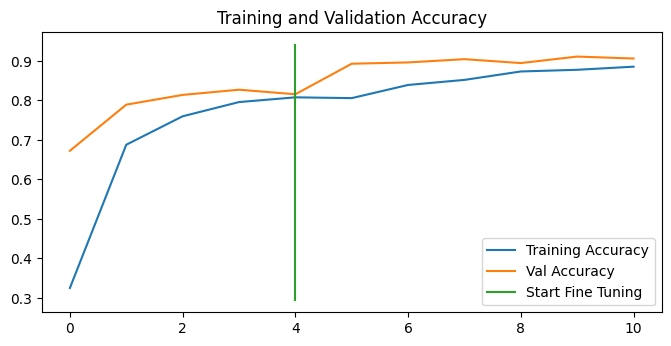

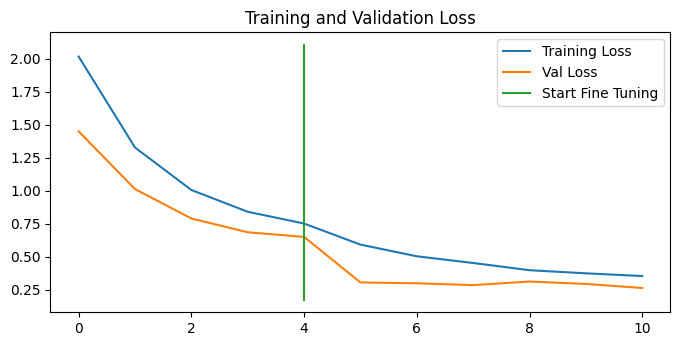

In [ ]:
# Comparing model_3 and model_4 How did fine-tuning do with mode data?
compare_historys(original_history=history_10_percent_data_aug,
                 new_history = history_fine_10_classes_full,
                 initial_epochs = 5)

## Viewing our experiment data on TensorBoard

**NOTE:** Anything uploaded to TensorBoard is public data. DO NOT SHARE PRIVATE/SENSITIVE INFO

In [ ]:
# View TensorBoard logs of transfer learning modelling experiments (should be ~ 4 models)
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./transfer_learning \
  --name "Transfer learning experiments" \
  --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning" \
  --one_shot # Exits the uploader when upload has finished

2023-07-20 05:56:46.363738: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./transfer_learning

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) no


Access the experiments here: https://tensorboard.dev/experiment/DHkZWRhkS7Wc1jkt7Gqrlg/#scalars

In [ ]:
# How to delete tensorboard posted experiments (just in case it's sensitive personal information that needs to be deleted)
!tensorboard dev list

# To delete experiment:
# !tensorboard dev delete --experiment_id DHkZWRhkS7Wc1jkt7Gqrlg

2023-07-20 06:04:54.806574: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will list all experiments that you've uploaded to
https://tensorboard.dev. TensorBoard.dev experiments are visible
to everyone. Do not upload sensitive data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   CHX-DZF-JLV


https://tensorboard.dev/experiment/DHkZWRhkS7Wc1jkt7Gqrlg/
	Name                 Transfer learning experime

In [ ]:
# Model 5: Take the good sides of model_0, which were no data augmentation, and the good sides of model_4, which was using all data and fine-tuning:



# Extra Curriculum exercices:

In [ ]:
# Re-compile model_2 (which will be model_4 once we fine-tune it)
model_0.compile(loss = "categorical_crossentropy",
               optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), # REMBER reduce lr by 10X !!!
               metrics = ['accuracy'])

In [ ]:
# 10. Fit model_5 AND save its history:
fine_tune_epochs = initial_epochs + 5
batch_size = 32

history_no_aug_full_data = model_0.fit(train_data_10_classes_full,
                                       epochs = fine_tune_epochs,
                                       validation_data = test_data_10_classes_full,
                                       validation_steps = len(test_data_10_classes_full) // batch_size,
                                       initial_epoch = history_10_percent.epoch[-1],
                                       callbacks = [create_tensorboard_callback(dir_name = "transfer_learning",
                                                                                experiment_name = "full_10_classes_fine_tuned_last_10_layers_no_aug")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tuned_last_10_layers_no_aug/20230720-060531
Epoch 5/10
235/235 [==============================] - 23s 70ms/step - loss: 0.6397 - accuracy: 0.8184 - val_loss: 0.4399 - val_accuracy: 0.9219
Epoch 6/10
235/235 [==============================] - 15s 64ms/step - loss: 0.5853 - accuracy: 0.8304 - val_loss: 0.5288 - val_accuracy: 0.8750
Epoch 7/10
235/235 [==============================] - 15s 64ms/step - loss: 0.5494 - accuracy: 0.8413 - val_loss: 0.4646 - val_accuracy: 0.8750
Epoch 8/10
235/235 [==============================] - 15s 64ms/step - loss: 0.5231 - accuracy: 0.8452 - val_loss: 0.4320 - val_accuracy: 0.9062
Epoch 9/10
235/235 [==============================] - 15s 63ms/step - loss: 0.5020 - accuracy: 0.8519 - val_loss: 0.3545 - val_accuracy: 0.8906
Epoch 10/10
235/235 [==============================] - 15s 64ms/step - loss: 0.4811 - accuracy: 0.8581 - val_loss: 0.3908 - val_accuracy: 0.8906


6
12
[0.8059999942779541, 0.8393333554267883, 0.8521333336830139, 0.8734666705131531, 0.8777333498001099, 0.8855999708175659, 0.8184000253677368, 0.8303999900817871, 0.8413333296775818, 0.8452000021934509, 0.8518666625022888, 0.8581333160400391]


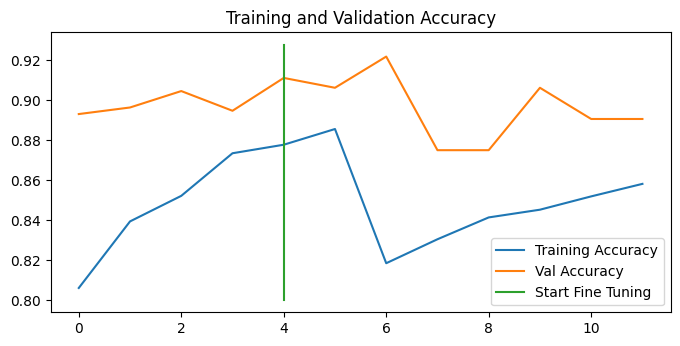

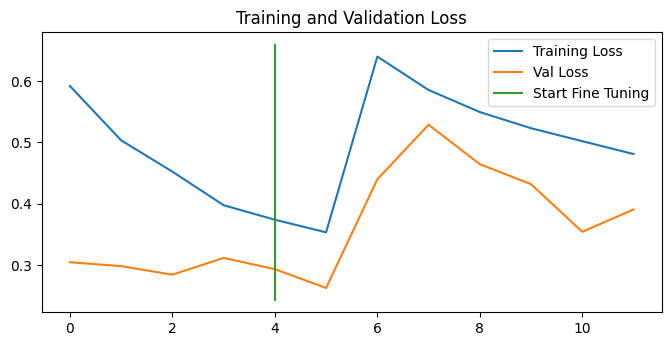

In [ ]:
# Comparing model_3 and model_4 How did fine-tuning do with mode data?
compare_historys(original_history = history_fine_10_classes_full,
                 new_history = history_no_aug_full_data,
                 initial_epochs = 5)

In [ ]:
### CONCLUSION: model_4 is the best. Model_5 underperformed. It seems like we over-fitted it!

##🛠 05. Transfer Learning in TensorFlow Part 2: Fine-tuning Exercises


1. Use feature-extraction to train a transfer learning model on 10% of the Food Vision data for 10 epochs using [tf.keras.applications.EfficientNetB0](https://www.tensorflow.org/api_docs/python/tf/keras/applications/EfficientNetB0) as the base model. Use the [ModelCheckpoint](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) callback to save the weights to file.
2. Fine-tune the last 20 layers of the base model you trained in 2 for another 10 epochs. How did it go?
3. Fine-tune the last 30 layers of the base model you trained in 2 for another 10 epochs. How did it go?
4. Write a function to visualize an image from any dataset (train or test file) and any class (e.g. "steak", "pizza"... etc), visualize it and make a prediction on it using a trained model.

**OTHER RESOURCES:**
* https://www.tensorflow.org/tutorials/images/data_augmentation
* https://arxiv.org/abs/1801.06146
* https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler

In [ ]:
# # Importing helper function:

# !wget "https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py"

# # Import helper functions we're going to use in this notebook:
# from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

In [ ]:
# Getting 10% of training data of 10 classes of Food101 (same dataset as in the previous notebook)

!wget "https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip"

unzip_data("10_food_classes_10_percent.zip")

--2023-07-20 06:07:11--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.23.128, 74.125.203.128, 74.125.204.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.23.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.3’

10_food_classes_10_ 100%[===================>] 160.74M  29.4MB/s    in 6.3s    

2023-07-20 06:07:18 (25.3 MB/s) - ‘10_food_classes_10_percent.zip.3’ saved [168546183/168546183]



In [ ]:
# Check out how many images and subdirectories there are in our dataset:
walk_through_dir("10_food_classes_10_percent.zip")

In [ ]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [ ]:
import tensorflow as tf

# Using ImageDataFromDirectory instead of ImageDataGenerator:BECAUSE ->>> It creates a much convinient data type (tf.data.Dataset) and it's much faster!
# Setting GLOBAL VARIABLES:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Preprocessing turns our data into batches:
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir,
                                                                            image_size = IMG_SIZE,
                                                                            label_mode = "categorical",
                                                                            batch_size = BATCH_SIZE)

test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir,
                                                                           image_size = IMG_SIZE,
                                                                           label_mode = "categorical",
                                                                           batch_size = BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train_data_10_percent

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [ ]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
# Create model:
base_model = tf.keras.applications.EfficientNetB0(include_top = False)

# 2. Freeze the base model (the underlying pre-trained patterns are not updated during training)
base_model.trainable = False

# 3. Create inputs into our model:
inputs = tf.keras.layers.Input(shape = (224, 224, 3),
                               name = 'input_layer')

# 4. IF using a model like ResNet50V2, we need to NORMALIZE inputs: (NO NEED TO NORALIZE FOR: EfficientNet(s))!!!!!!!
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255) (inputs) ### Pros of using Functional API -> We can normalize data into our model!

# 5. Pass inputs to base model:
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important info AND reduce number of computations):
x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the outputs activation layer:
outputs = tf.keras.layers.Dense(10, activation = 'softmax', name = 'output_layer')(x)

###################################################
#################### MODEL ########################
###################################################

# 8. Combine inputs with outputs into a model:
model_0A = tf.keras.Model(inputs, outputs)

# 9. Compile model_0:
model_0A.compile(loss = tf.keras.losses.categorical_crossentropy, ### IMPORTANT: USE -> categorical_crossentropy NOT CategoricalCrossentropy !!!
                optimizer = tf.keras.optimizers.Adam(), ### We don't divide lr by 10X, yet, this action will be performed once we start fine-tuning!
                metrics = ['accuracy'])

# 10. Fit model_0 AND save its history:
history_10_percent_0A = model_0A.fit(train_data_10_percent,
                      epochs = 5,
                      steps_per_epoch = len(train_data_10_percent),
                      validation_data = test_data_10_percent,
                      validation_steps =int(0.25*len(test_data_10_percent)), # This only validates 25% of all the test data, so for this experiment it fits faster!
                      callbacks = [create_tensorboard_callback(dir_name = "transfer_learning",
                                                               experiment_name = "10_percent_feature_extraction")])

Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20230720-060723
Epoch 1/5
24/24 [==============================] - 12s 189ms/step - loss: 1.8470 - accuracy: 0.4467 - val_loss: 1.2783 - val_accuracy: 0.7664
Epoch 2/5
24/24 [==============================] - 3s 120ms/step - loss: 1.0734 - accuracy: 0.7747 - val_loss: 0.8699 - val_accuracy: 0.8273
Epoch 3/5
24/24 [==============================] - 3s 120ms/step - loss: 0.7779 - accuracy: 0.8293 - val_loss: 0.7179 - val_accuracy: 0.8487
Epoch 4/5
24/24 [==============================] - 3s 121ms/step - loss: 0.6354 - accuracy: 0.8493 - val_loss: 0.6034 - val_accuracy: 0.8684
Epoch 5/5
24/24 [==============================] - 3s 120ms/step - loss: 0.5350 - accuracy: 0.8867 - val_loss: 0.5550 - val_accuracy: 0.8717


In [ ]:
model_0A.evaluate(test_data_10_percent)

79/79 [==============================] - 5s 60ms/step - loss: 0.5473 - accuracy: 0.8652


[0.5473426580429077, 0.8651999831199646]

In [ ]:
# Setting the last 20 layers of our base_model.trainable = True:
base_model.trainable = True

# Freeze all layers except for the last 10:
for layer in base_model.layers[:-20]:
  layer.trainable = False

# Recompile model (We must recompile our models every time a change is made)
model_0A.compile(loss = "categorical_corssentropy",
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
                metrics = ['accuracy'])

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Creating data augmentation stage with horizontal flipping, rotations, zooms...
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocessing.Rescaling(1./255) ### Keep for models such as ResNet50V2, but EfficientNet have rescaling built-in, so we don't need it here!


], name = "data_augmentation")

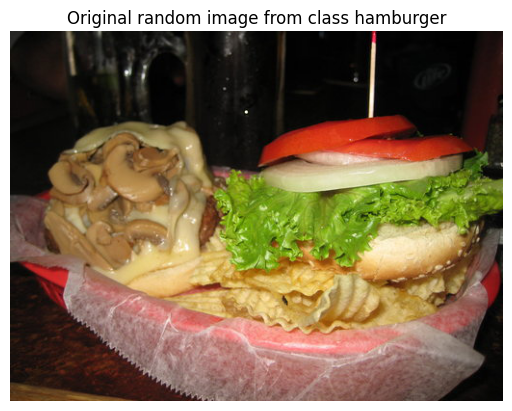

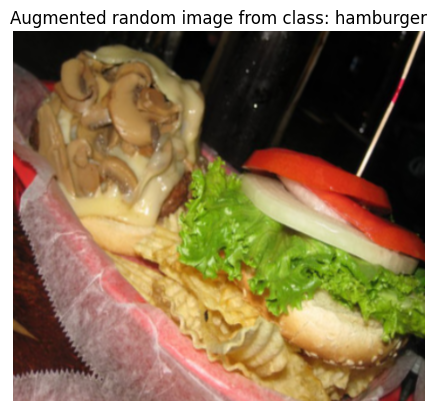

In [ ]:
# View a random image and compare it to its augmented version:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

taget_class = random.choice(train_data_10_percent.class_names)
target_dir = "10_food_classes_10_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read in the random image:
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class {target_class}")
plt.axis(False);

augmented_img = data_augmentation(tf.expand_dims(img, axis = 0))
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

In [ ]:
###################################################
#################### MODEL ########################
###################################################

# 8. Combine inputs with outputs into a model:
model_0A = tf.keras.Model(inputs, outputs)

# 9. Compile model_0:
model_0A.compile(loss = tf.keras.losses.categorical_crossentropy, ### IMPORTANT: USE -> categorical_crossentropy NOT CategoricalCrossentropy !!!
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), ### We don't divide lr by 10X, yet, this action will be performed once we start fine-tuning!
                metrics = ['accuracy'])

# 10. Fit model_0 AND save its history:
history_10_percent_0A_20_layers = model_0A.fit(train_data_10_percent,
                                               epochs = 10,
                                               steps_per_epoch = len(train_data_10_percent),
                                               validation_data = test_data_10_percent,
                                               validation_steps =int(0.25*len(test_data_10_percent)), # This only validates 25% of all the test data, so for this experiment it fits faster!
                                               callbacks = [create_tensorboard_callback(dir_name = "transfer_learning",
                                                                                        experiment_name = "10_percent_feature_extraction")])

Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20230720-070216
Epoch 1/10
24/24 [==============================] - 15s 208ms/step - loss: 0.0108 - accuracy: 0.9987 - val_loss: 0.6038 - val_accuracy: 0.8865
Epoch 2/10
24/24 [==============================] - 4s 129ms/step - loss: 0.0059 - accuracy: 0.9987 - val_loss: 0.6391 - val_accuracy: 0.8750
Epoch 3/10
24/24 [==============================] - 4s 175ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.5325 - val_accuracy: 0.8964
Epoch 4/10
24/24 [==============================] - 3s 131ms/step - loss: 0.0045 - accuracy: 0.9987 - val_loss: 0.5606 - val_accuracy: 0.8849
Epoch 5/10
24/24 [==============================] - 3s 128ms/step - loss: 0.0075 - accuracy: 0.9973 - val_loss: 0.5004 - val_accuracy: 0.8997
Epoch 6/10
24/24 [==============================] - 3s 126ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.4730 - val_accuracy: 0.9046
Epoch 7/10
24/24 [==============================] 

In [ ]:
base_model.trainable = True

# Freeze all layers except for the last 10:
for layer in base_model.layers[:-30]:
  layer.trainable = False


In [ ]:
###################################################
#################### MODEL ########################
###################################################

# 8. Combine inputs with outputs into a model:
model_1A = tf.keras.Model(inputs, outputs)

# 9. Compile model_0:
model_1A.compile(loss = tf.keras.losses.categorical_crossentropy, ### IMPORTANT: USE -> categorical_crossentropy NOT CategoricalCrossentropy !!!
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), ### We don't divide lr by 10X, yet, this action will be performed once we start fine-tuning!
                metrics = ['accuracy'])

# 10. Fit model_0 AND save its history:
history_10_percent_1A_30_layers = model_0A.fit(train_data_10_percent,
                                               epochs = 10,
                                               steps_per_epoch = len(train_data_10_percent),
                                               validation_data = test_data_10_percent,
                                               validation_steps =int(0.25*len(test_data_10_percent)), # This only validates 25% of all the test data, so for this experiment it fits faster!
                                               callbacks = [create_tensorboard_callback(dir_name = "transfer_learning",
                                                                                        experiment_name = "10_percent_feature_extraction")])

Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20230720-070315
Epoch 1/10
24/24 [==============================] - 3s 126ms/step - loss: 0.0039 - accuracy: 0.9987 - val_loss: 0.5207 - val_accuracy: 0.8898
Epoch 2/10
24/24 [==============================] - 3s 127ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.4964 - val_accuracy: 0.8947
Epoch 3/10
24/24 [==============================] - 3s 124ms/step - loss: 0.0074 - accuracy: 0.9987 - val_loss: 0.5267 - val_accuracy: 0.8914
Epoch 4/10
24/24 [==============================] - 3s 124ms/step - loss: 0.0030 - accuracy: 0.9987 - val_loss: 0.5339 - val_accuracy: 0.8898
Epoch 5/10
24/24 [==============================] - 3s 124ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.5463 - val_accuracy: 0.8898
Epoch 6/10
24/24 [==============================] - 3s 125ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.5120 - val_accuracy: 0.8964
Epoch 7/10
24/24 [==============================] -

In [ ]:
model_1A.evaluate(test_data_10_classes_full)

79/79 [==============================] - 5s 61ms/step - loss: 0.4442 - accuracy: 0.8960


[0.44415533542633057, 0.8960000276565552]

In [ ]:
model_0A.evaluate(test_data_10_classes_full)

79/79 [==============================] - 5s 61ms/step - loss: 0.4442 - accuracy: 0.8960


[0.44415533542633057, 0.8960000276565552]

In [ ]:
model_1A.predict()